In [137]:
#%pip install yfinance numpy statsmodels pandas matplotlib arch openpyxl


In [184]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
from arch.univariate import SkewStudent
from scipy.stats import norm, t, multivariate_t, chi2
from scipy.optimize import minimize

#from statsmodels.distributions.copula.api import StudentTCopula

from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

##### Import Data
This cell imports index data from Yahoo Finance, using the yFinance library, or alternatively, loads previously cached data.

In [139]:

# List of ticker symbols for each index
tickers = ["^GDAXI", "^AEX", "^FTSE", "^N225", "^GSPC", "^GSPTSE"]  # DAX, AEX, FTSE 100 Nikkei 225, S&P 500, TSX
index_datasets = {}

#Set to True to download data from Yahoo Finance using the yFinance library
#Set to False to use previously cached data
DOWNLOAD_DATA = True


if DOWNLOAD_DATA:
    # Loop over each ticker symbol to fetch the data
    for ticker in tickers:
        # Retrieve the historical data starting from November 20, 1992
        index = yf.Ticker(ticker)
        #Save to dictionary
        index_datasets[ticker] = index.history(start="1950-11-20")   #(start="1992-11-20")

        # Convert the Date column to Datetime
        (index_datasets[ticker]).index = pd.to_datetime((index_datasets[ticker]).index.normalize().tz_localize(None))
        
        index_datasets[ticker] = round(index_datasets[ticker],12)

        #Write data to disk
        index_datasets[ticker].to_excel(".\\Saved Data\\"+ticker+'.xlsx', index=True)
else:
    import os
    # Loop over each ticker symbol
    for ticker in tickers:
        # File path to saved data
        file_path = os.path.join(".\\Saved Data\\"+ticker+'.xlsx')
        
        if os.path.exists(file_path):
            # Load the saved data from Excel
            index_data = pd.read_excel(file_path, index_col=0, parse_dates=True)
            
            # Convert the Date column to Datetime
            index_data.index = pd.to_datetime(index_data.index.normalize().tz_localize(None))

            # Save it to the dictionary
            index_datasets[ticker] = round(index_data,12)
            
            # Optional: Print the first few rows of the data for verification
            print(f"Loaded data for {ticker}:\n", index_data.head())
        else:
            print(f"Excel file for {ticker} not found at {file_path}")


    

##### Compute log-returns

We merge all of the data stored in the index_datasets dictionary into one Pandas dataframe. We sample the data on a monthly basis, using a forward fill to account for any missing dates. The forward fill is required to account for different exchanges having different holidays. We then compute the monthly log-returns for each index. We then drop all data apart from the date and monthly log-returns from our dataframe.


In [181]:
# Initialize a DataFrame to store merged data
merged_data = pd.DataFrame()
k=0
# Loop over each ticker symbol to fetch the data
for ticker in tickers:
    
    index_data = index_datasets[ticker]

    # Extract only the Date and Close columns, reset the index
    close_data = (index_data[['Close']]).copy()

    close_data.rename(columns={'Close': ticker},inplace=True)

    
    # Merge with the previously merged data
    if merged_data.empty:
        merged_data = close_data
    else:
        merged_data = pd.merge(merged_data, close_data, on='Date')



for ticker in tickers:
    #Forward fill missing data
    merged_data[ticker] = merged_data[ticker].ffill()


#Resample at end of each month
merged_data = merged_data.resample("M").last()

#Compute Log Returns
merged_data[:] = np.log(1+merged_data.pct_change())

#Alternatively, can use simple returns
#merged_data[:] = merged_data.pct_change()

merged_data.dropna(inplace=True)



C:\Users\liamm\AppData\Local\Temp\ipykernel_26876\3281886305.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  merged_data = merged_data.resample("M").last()


##### Compute Emperical Moments

In [141]:
# Create a dataframe for the first four empirical moments (mean, variance, skewness, kurtosis)
print("Empirical moments for each index's monthly log-returns:\n")
moments_df = pd.DataFrame(columns=['Mean', 'Variance', 'Skewness', 'Kurtosis'], index=tickers)

# Calculate and print empirical moments for each ticker
for ticker in tickers:
    data = merged_data[ticker] 
    moments_df.loc[ticker, 'Mean'] = data.mean()
    moments_df.loc[ticker, 'Variance'] = data.var()
    moments_df.loc[ticker, 'Skewness'] = data.skew()
    moments_df.loc[ticker, 'Kurtosis'] = data.kurtosis()

print(moments_df)   

Empirical moments for each index's monthly log-returns:

             Mean  Variance  Skewness  Kurtosis
^GDAXI    0.00678  0.003426 -0.828977  2.760523
^AEX     0.005115  0.002822 -0.937179  2.610579
^FTSE     0.00295   0.00151 -0.702183  1.197259
^N225    0.002218  0.003133 -0.588058  1.236281
^GSPC    0.006919  0.001816 -0.664193  1.206515
^GSPTSE  0.005246  0.001731 -1.060429  3.597135


##### Fit Models
Here, we first fit a Students-t GARCH model to the log-return data for each index, using the arch library.

To do this, we must first decide what order $(p)$ to use for the GARCH terms $(\sigma^2_t)$, and what order $(q)$ to use for the ARCH Terms $(\epsilon_t)$.

We will test different pairs of $(p,q)$, and choose the one with the lowest average Akaike Information Criterion (AIC) across all distributions and indices.

Note: We are actually fitting the GARCH model to 100 times the log-return data, as recommended by the library documentation. This is done to improve numerical stability. 


In [151]:
aic_min_model = "Empty"
min_combination_model = ("normal",1,1)

distributions = ("normal","t","skewt")

combinations = [(i, j) for i in range(1, 5) for j in range(1, 5)]
# i.e. [(1,1),(1,2),...,(1,4),(2,1),(2,2),...,(4,4)]


best_AIC = pd.DataFrame(np.inf,columns=tickers, index = distributions)
best_pair = pd.DataFrame(columns=tickers, index = distributions)

for dist in distributions:
    for (p,q) in combinations:
        for ticker in tickers:
            # as suggested by the documentation, we scale our data to improve numerical stability
            model = arch_model(merged_data[ticker]*100, vol="Garch", p=p, q=q, dist=dist, rescale=False)  
            aic = model.fit(options={'maxiter': 1000, 'ftol': 1e-8},disp="off").aic

            if best_AIC.loc[dist,ticker] > aic:
                best_AIC.loc[dist,ticker] = aic
                best_pair.loc[dist,ticker] = (p,q)

print(best_pair)
print(best_AIC)





        ^GDAXI    ^AEX   ^FTSE   ^N225   ^GSPC ^GSPTSE
normal  (1, 1)  (1, 1)  (1, 1)  (1, 1)  (1, 1)  (1, 1)
t       (1, 1)  (1, 1)  (1, 1)  (1, 1)  (1, 1)  (1, 1)
skewt   (1, 1)  (1, 1)  (1, 1)  (1, 1)  (1, 1)  (1, 1)
             ^GDAXI         ^AEX        ^FTSE        ^N225        ^GSPC  \
normal  2422.367950  2314.171820  2112.098572  2424.171990  2156.037124   
t       2398.195142  2309.648998  2108.117539  2422.094865  2155.100449   
skewt   2385.316706  2295.414341  2092.396406  2410.817482  2132.136408   

            ^GSPTSE  
normal  2146.815129  
t       2130.731102  
skewt   2114.749989  


The above results suggest that GARCH(1,1) models best fit our data, for all distribution/index pairs. Also, the skewed Student's-t GARCH(1,1) model has the best fit for all indices, as evident by its relatively lower AIC.

Thus, it is best if we set the order of our GARCH and ARCH terms to (1,1), for each index and distribution.


Next, we will save our normal, Student's-t and skewed Student's-t GARCH(1,1) models, as well as their standarized residuals.

In [143]:
fitted_models = {}
std_residuals = {}

#Fit each GARCH model, store models in fitted_models dictionary and standarized residuals in std_residuals dictionary
for dist in distributions:
    for ticker in tickers:
        # as suggested by the documentation, we scale our data to improve numerical stability
        model = arch_model(merged_data[ticker]*100, vol="Garch", p=1, q=1, dist=dist, rescale=False)  
        fitted_models[(ticker,dist)] = model.fit(options={'maxiter': 1000, 'ftol': 1e-8},disp="off")
        std_residuals[(ticker,dist)] = fitted_models[(ticker,dist)].resid / fitted_models[(ticker,dist)].conditional_volatility



#Creates a dataframe with the fitted parameters from each model, and prints results
print("Fitted parameters for each model:\n")
for dist in distributions:
    df = pd.DataFrame(columns=tickers)
    for ticker in tickers:
        df[ticker] = fitted_models[(ticker,dist)].params
    print("\nModel: "+dist)
    print(round(df,10)) 

    if dist == "t":
        min_nu = sorted(df.loc['nu'])[0]
        max_nu = sorted(df.loc['nu'])[-1]
        max_nu_2 = sorted(df.loc['nu'])[-2]
    
    if dist == "skewt":
        min_eta = sorted(df.loc['eta'])[0]
        max_eta = sorted(df.loc['eta'])[-1]
        max_eta_2 = sorted(df.loc['eta'])[-2]
   

Fitted parameters for each model:


Model: normal
            ^GDAXI      ^AEX     ^FTSE      ^N225     ^GSPC   ^GSPTSE
mu        0.976348  0.823608  0.482408   0.316347  0.873786  0.833109
omega     4.444549  3.083015  1.462297  12.537884  1.000658  2.368361
alpha[1]  0.195235  0.268159  0.171780   0.115888  0.188648  0.348572
beta[1]   0.685439  0.635378  0.736943   0.482715  0.765660  0.563885

Model: t
            ^GDAXI      ^AEX     ^FTSE      ^N225      ^GSPC   ^GSPTSE
mu        1.191358  0.915325  0.612994   0.482346   0.980429  0.819696
omega     3.310456  3.454309  1.649853   2.639478   0.987663  1.455715
alpha[1]  0.188049  0.252490  0.185908   0.054597   0.193727  0.190068
beta[1]   0.727941  0.631797  0.713708   0.859528   0.764038  0.736818
nu        5.895466  9.324354  9.175544  12.505871  11.958767  6.735854

Model: skewt
            ^GDAXI       ^AEX      ^FTSE      ^N225      ^GSPC   ^GSPTSE
mu        0.870184   0.710812   0.457652   0.298770   0.841671  0.600447
omeg

Recall that we scaled our log-returns by a factor of $100$ before fitting each model. Hence, our mean returns (mu) above are scaled by a factor of $100$, while our baseline variances (omega) are scaled by a factor of $100^2$

We note that, in each model, the Nikkei 225 has a low alpha parameter, suggesting a lack of volatility clustering. Additionally, we note that, when compared to the other indices, the Nikkei 225 log-returns distribution demonstrates thinner tails, as demonstrated by the greater degrees of freedom in both the classical and skewed Student's-t GARCH models.

The other indices are distributed with much fatter tails, with fitted degrees of freedom ranging between 5.67 - 9.18, and 6.54 - 13.95 for the classical and skewed Student's-t GARCH models, respectively.

We observe that each index's returns are negatively skewed, as evident by the lambda parameter in the skewed Student's-t GARCH models.


##### Plot ACF of Standardized Residuals

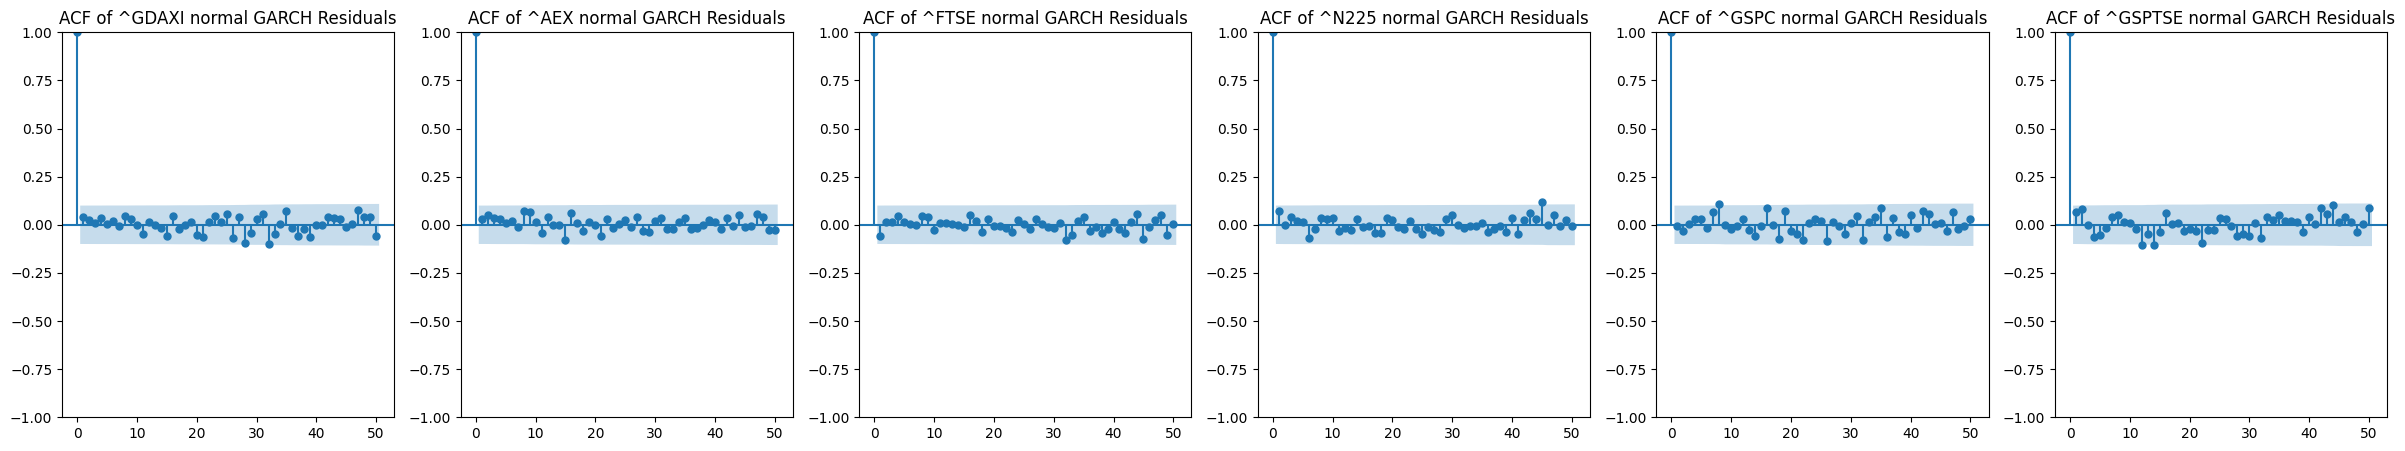

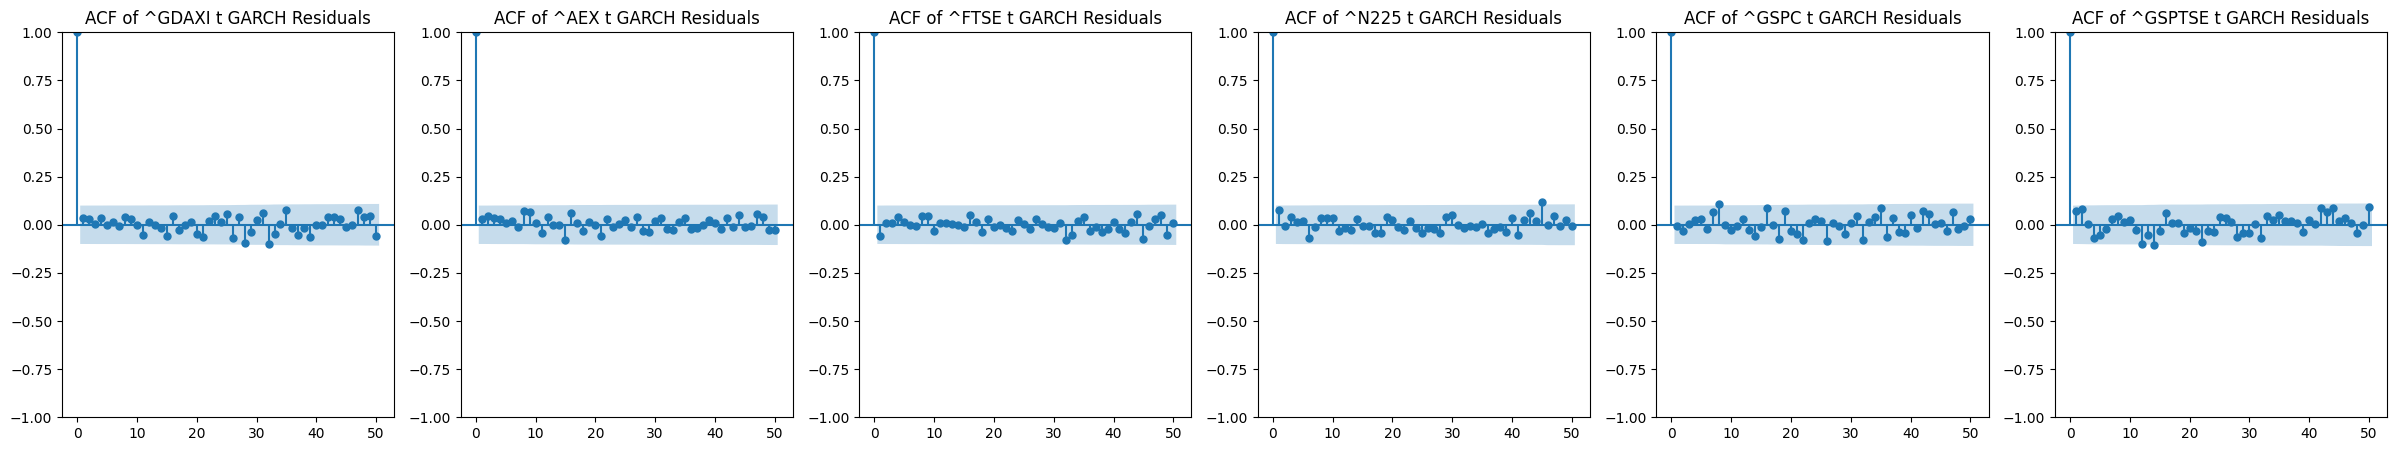

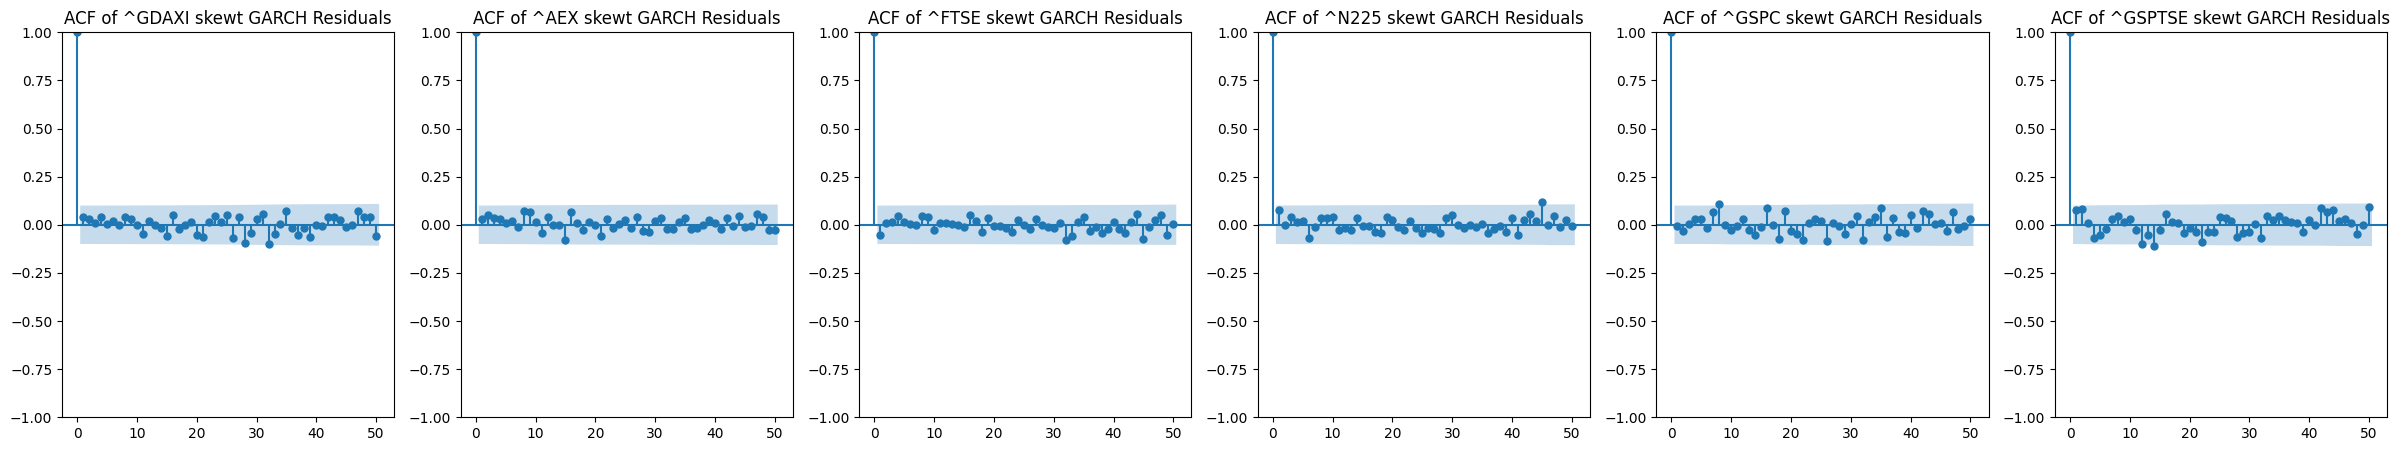

In [144]:
#This plots the ACF of the residuals of each GARCH, and displays them side by side for comparision
for dist in distributions:
    num_tickers = len(tickers)
    fig, axes = plt.subplots(1, num_tickers, figsize=(5 * num_tickers, 5))
    for i in range(num_tickers):
        ticker = tickers[i]
        plot_acf(std_residuals[(ticker,dist)], lags=50, ax=axes[i]) 
        axes[i].set_title('ACF of ' + ticker + " " + dist + ' GARCH Residuals')


The above results suggest that there is little autocorrelation in the stardarized residuals of our fitted GARCH models.

##### Plot ACF of Squared Standardized Residuals

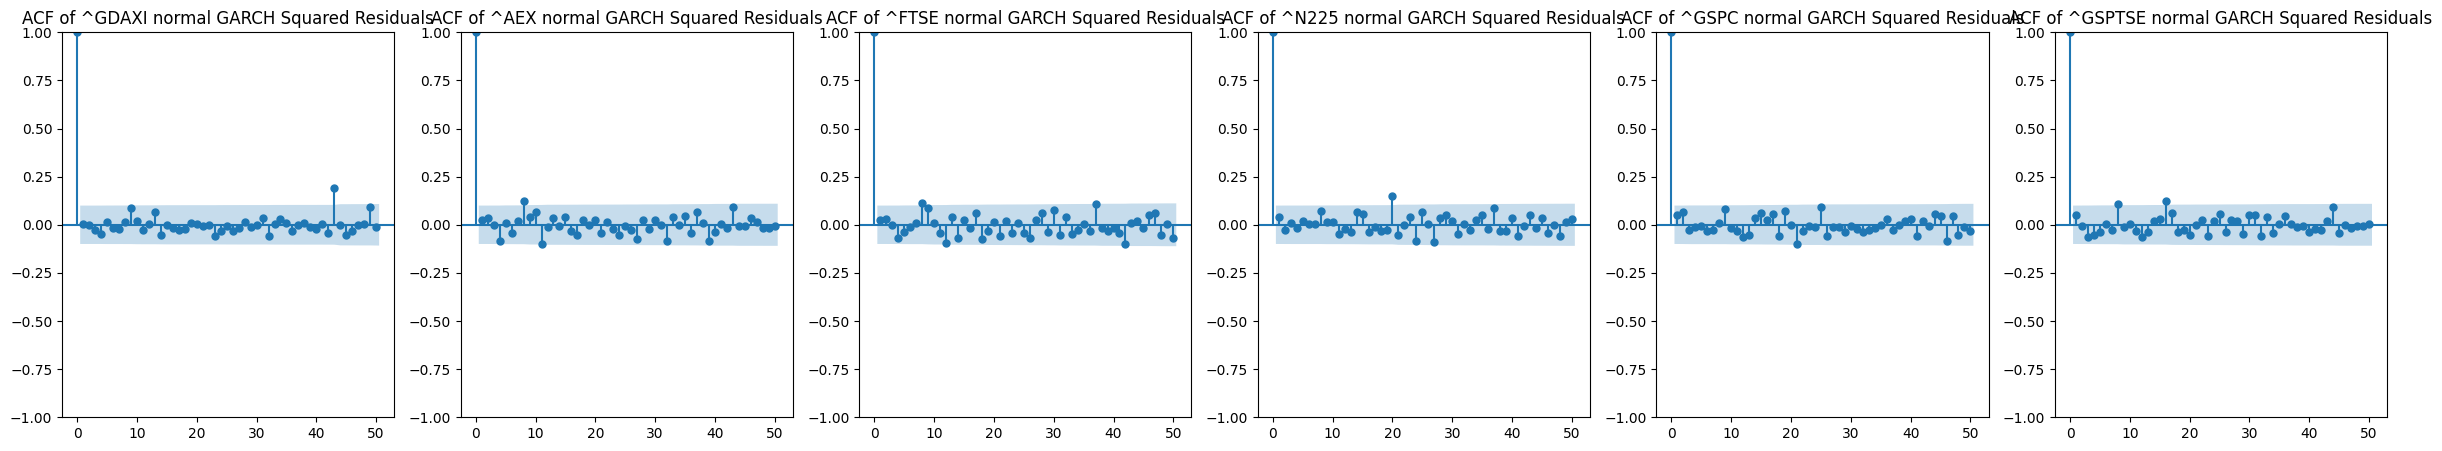

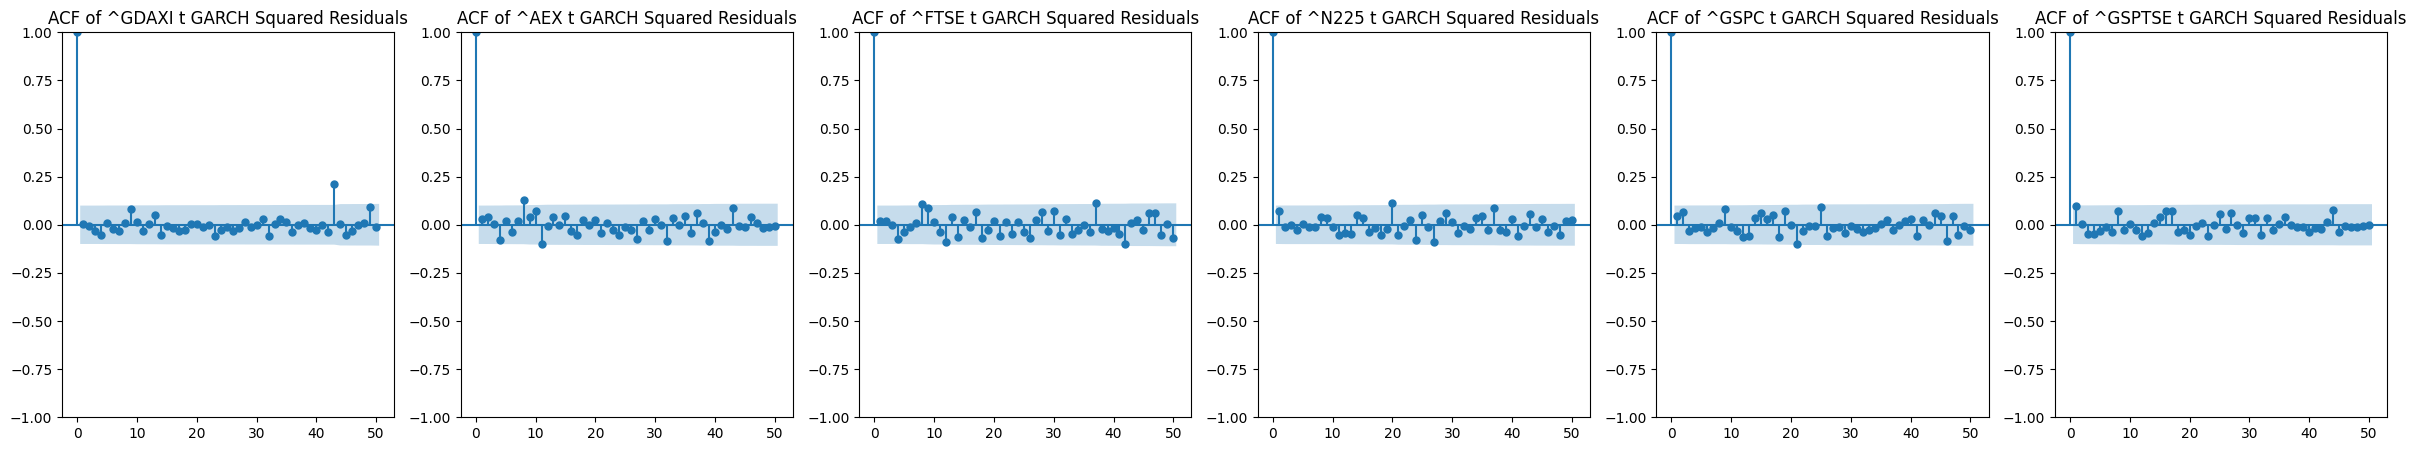

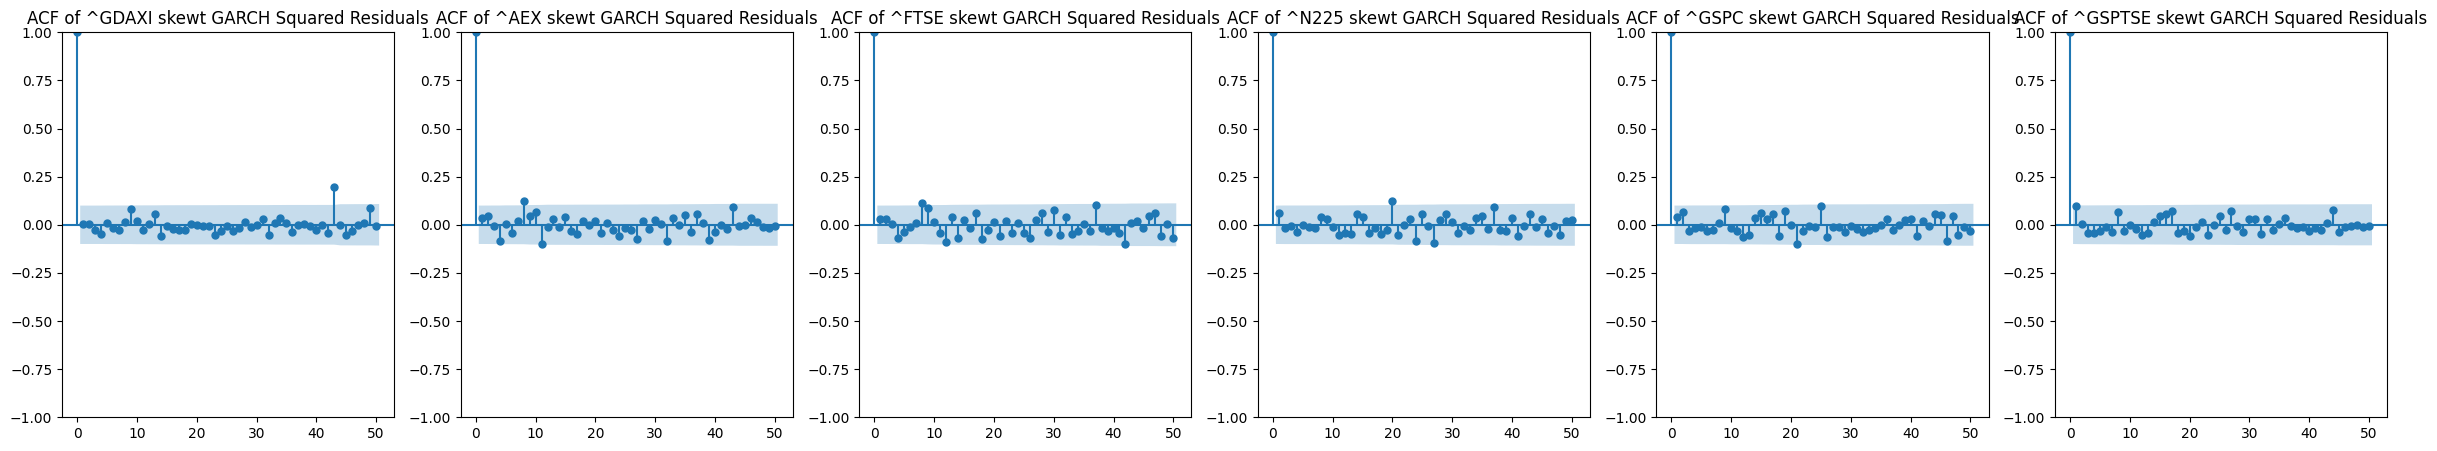

In [145]:

#This plots the ACF of the squared residuals of each GARCH, and displays them side by side for comparision
for dist in distributions:
    num_tickers = len(tickers)
    fig, axes = plt.subplots(1, num_tickers, figsize=(5 * num_tickers, 5))
    for i in range(num_tickers):
        ticker = tickers[i]
        plot_acf(std_residuals[(ticker,dist)]**2, lags=50, ax=axes[i]) 
        axes[i].set_title('ACF of ' + ticker + " " + dist + ' GARCH Squared Residuals')



The above results suggest that there is little autocorrelation in the stardarized squared residuals of our fitted GARCH models.

##### Plot QQ Plot for residuals

QQ Plots of normal GARCH Residuals


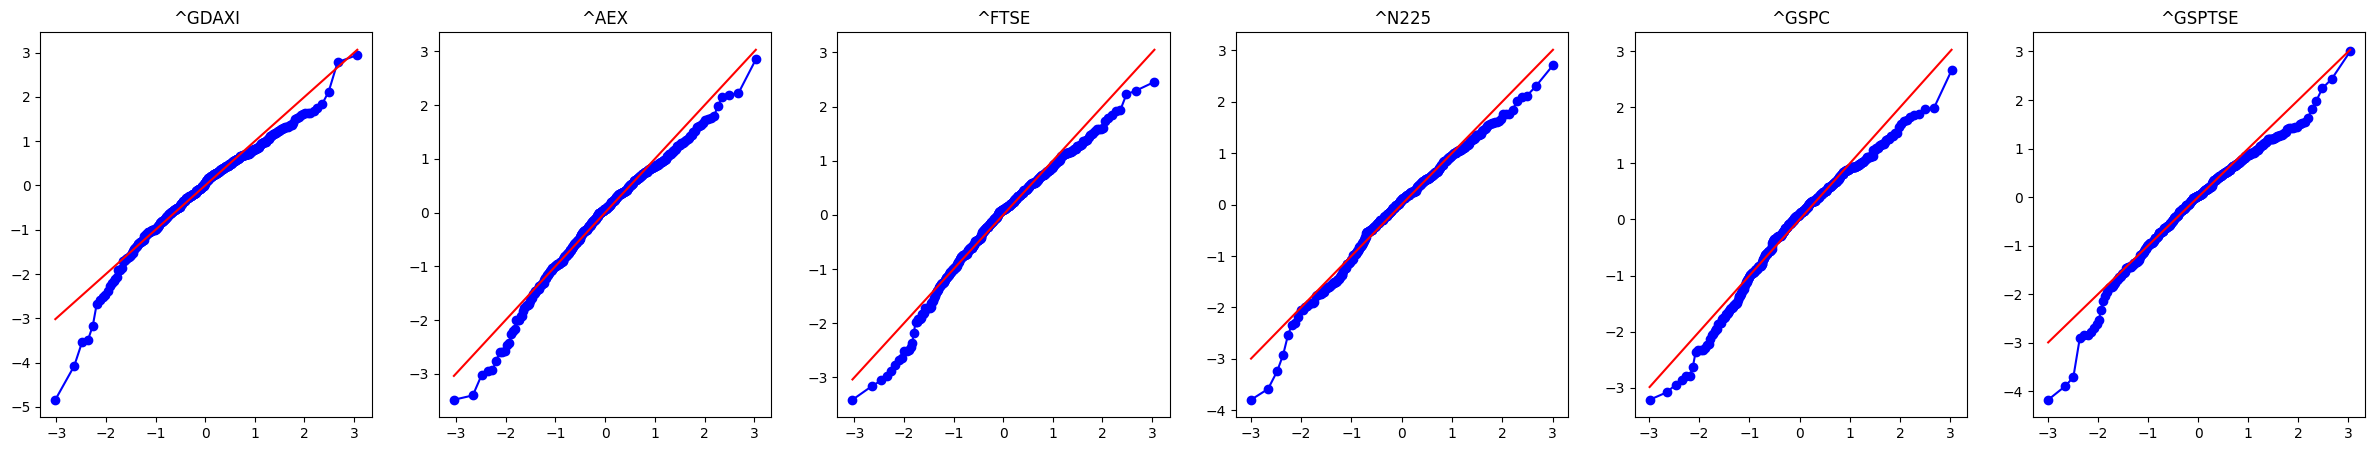

QQ Plots of t GARCH Residuals


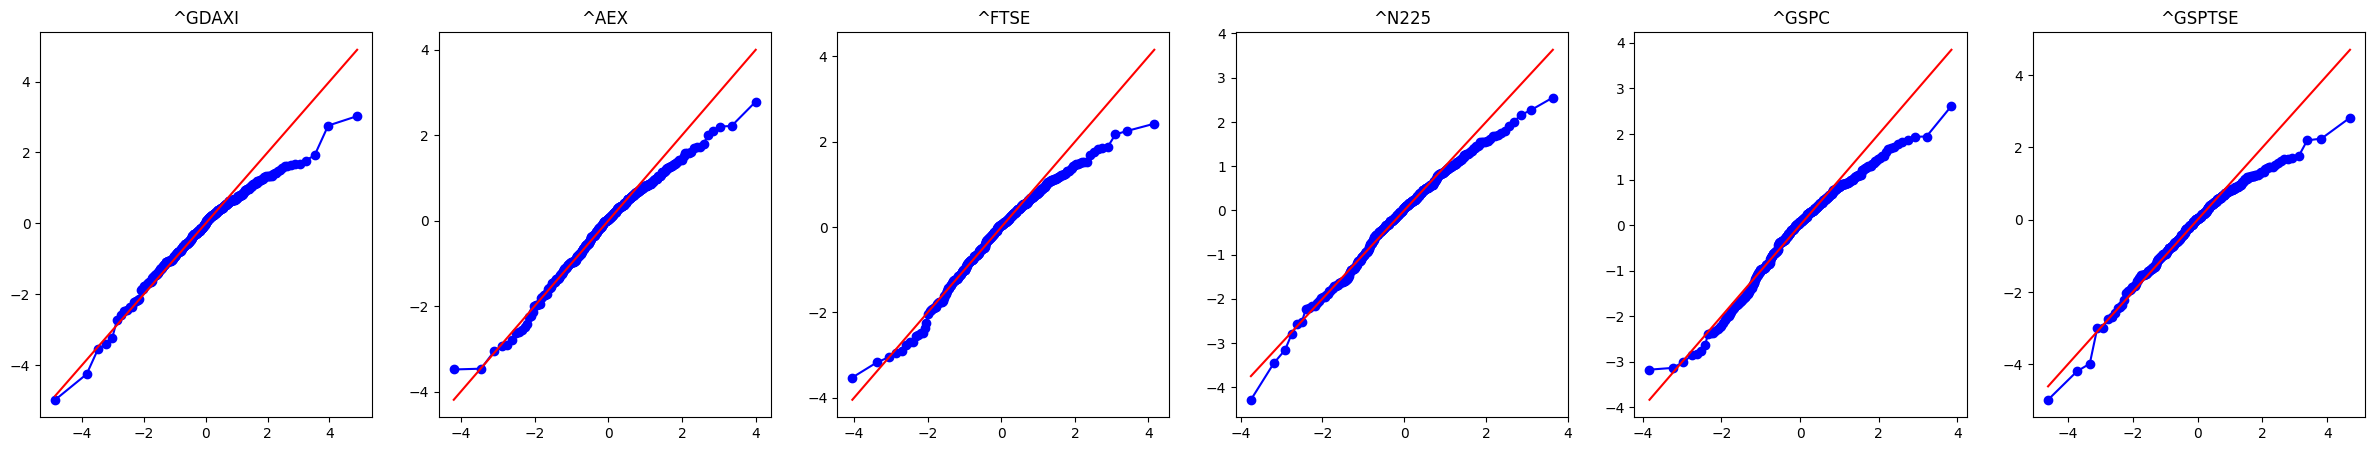

QQ Plots of skewt GARCH Residuals


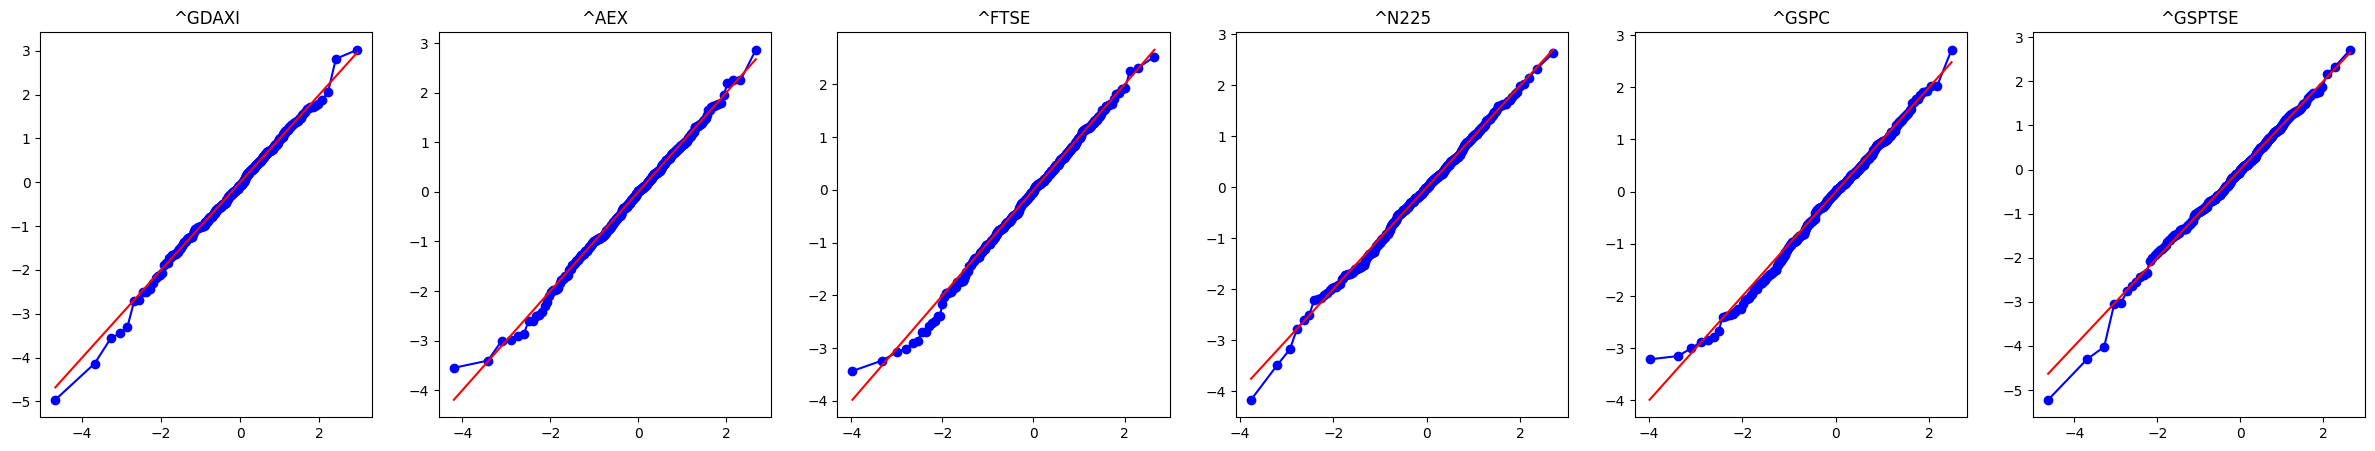

In [146]:

#This plots the ACF of the squared residuals of each GARCH, and displays them side by side for comparision
for dist in distributions:
    print('QQ Plots of ' + dist + ' GARCH Residuals')
    num_tickers = len(tickers)
    fig, axes = plt.subplots(1, num_tickers, figsize=(5 * num_tickers, 5))

    n = len(merged_data)
    quantiles = (np.arange(1, n + 1) - 0.5) / n

    for i in range(num_tickers):
        
        ticker = tickers[i]

        if dist == 'normal': theoretical_quantiles  =  np.quantile(norm.rvs(0,1,100000), quantiles)

        elif dist == 't':
            nu =  fitted_models[(ticker,dist)].params["nu"]
            theoretical_quantiles  =  np.quantile(t.rvs(nu,0,1,100000), quantiles)

        elif dist == 'skewt': 
            eta = fitted_models[(ticker,dist)].params["eta"]
            lambda_param = fitted_models[(ticker,dist)].params["lambda"]
            skew_t_rvs = SkewStudent().simulate(parameters=[eta, lambda_param])
            theoretical_quantiles  =  np.quantile(skew_t_rvs(100000), quantiles)

        sorted_std_residuals = sorted(std_residuals[(ticker,dist)])
     
        axes[i].plot(theoretical_quantiles,sorted_std_residuals,color = "blue", marker = 'o')
        axes[i].plot(theoretical_quantiles,theoretical_quantiles,color = "red")
        axes[i].set_title(ticker)

    plt.show()
        




The above results suggest that the skewed Student's-t distribution has the best fit, across all indices.



However, most of the our models predict slightly more extreme negtaive shocks than the data suggests, as evident by bottom left regions in the above QQ Plots.

# Compute Spearman's Variance-Covariance Matrix
Using the standarized residuals from our Student's t GARCH model, we calculate the spearman correlation of the standarized residuals.

In [147]:
spearman_rho = {
    "normal" : pd.DataFrame(columns=tickers, index = tickers),
    "t" : pd.DataFrame(columns=tickers, index = tickers),
    "skewt" : pd.DataFrame(columns=tickers, index = tickers),

}

print("Spearman Correlation Matrix of Standarized Residuals")
for dist in distributions:
    for ticker_1 in tickers:
        for ticker_2 in tickers:

            ranked_residuals_1 = pd.Series(std_residuals[(ticker_1,dist)]).rank(method='average')
            ranked_residuals_2 = pd.Series(std_residuals[(ticker_2,dist)]).rank(method='average') 
            
            spearman_rho[dist].loc[ticker_1,ticker_2] = np.corrcoef(ranked_residuals_1,ranked_residuals_2)[0][1]
            
    print("GARCH Distribution: ",dist)
    print(spearman_rho[dist])
    print()

Spearman Correlation Matrix of Standarized Residuals
GARCH Distribution:  normal
           ^GDAXI      ^AEX     ^FTSE     ^N225     ^GSPC   ^GSPTSE
^GDAXI        1.0  0.833304  0.722936  0.528994  0.715008  0.636357
^AEX     0.833304       1.0  0.746466  0.526727  0.714415  0.642147
^FTSE    0.722936  0.746466       1.0   0.41636  0.685544  0.668958
^N225    0.528994  0.526727   0.41636       1.0  0.513085  0.433279
^GSPC    0.715008  0.714415  0.685544  0.513085       1.0  0.725919
^GSPTSE  0.636357  0.642147  0.668958  0.433279  0.725919       1.0

GARCH Distribution:  t
           ^GDAXI      ^AEX     ^FTSE     ^N225     ^GSPC   ^GSPTSE
^GDAXI        1.0  0.833614  0.722562  0.530749   0.71298  0.635838
^AEX     0.833614       1.0  0.746125  0.530039  0.713745  0.646654
^FTSE    0.722562  0.746125       1.0  0.416288  0.683253  0.672929
^N225    0.530749  0.530039  0.416288       1.0  0.514293  0.438395
^GSPC     0.71298  0.713745  0.683253  0.514293       1.0  0.728542
^GSPTSE  0.

##### Fit Student's-t Copula
Next, we will fit our Student's-t copula to our normal, Student's-t and skewed Student's-t GARCH marginals. To do this, we will use the Spearman correlation matrix from above, and estimate the degrees of freedom.



In [182]:
mu = merged_data.mean(axis=0)

normal_residuals = np.array([std_residuals[(ticker, "normal")] for ticker in tickers])
t_residuals_df = np.array([std_residuals[(ticker, "t")] for ticker in tickers])
skewt_residuals_df = np.array([std_residuals[(ticker, "skewt")] for ticker in tickers])


def negative_mvt_log_likelihood(df,x,dist):
    return -1*sum(multivariate_t.logpdf(x[:,i],df=df,loc=mu,shape = spearman_rho[dist].to_numpy(dtype=float)) for i in range(len(x)))

normal_optimize_result = minimize(negative_mvt_log_likelihood,[10], args = (normal_residuals,"normal",),bounds = [(1,1000)])
t_optimize_result = minimize(negative_mvt_log_likelihood,[10], args = (normal_residuals,"t",),bounds = [(1,1000)])
skewt_optimize_result = minimize(negative_mvt_log_likelihood,[10], args = (normal_residuals,"skewt",),bounds = [(1,1000)])

print("Multivariate-t fitted degrees of freedom for standaridized residuals:")
print("Normal:",normal_optimize_result.x)
print("Student's-t:",t_optimize_result.x)
print("Skewed Student's-t:",skewt_optimize_result.x)





'''
D, p_value = kstest(normal_residuals.flatten(), 't', args=(df, mu, spearman_rho[ "normal"].to_numpy(dtype=float)))



normal_cov_inverse = np.linalg.inv(spearman_rho["normal"].to_numpy(dtype=float))

def mahalanobis_distance(x):
    return np.sqrt(np.dot(np.dot(x-mu, normal_cov_inverse), (x-mu).T))



len(normal_residuals)

quantiles = (np.arange(1, len(normal_residuals) + 1) - 0.5) / len(normal_residuals)

sorted_normal_residuals = np.argsort([mahalanobis_distance(row) for row in normal_residuals.T])

observed_data = multivariate_t.rvs(loc=mu,shape =spearman_rho[ "normal"].to_numpy(dtype=float) ,df=normal_optimize_result.x, size=10000)


actual_quantiles = np.quantile(sorted_normal_residuals,quantiles)
theoretical_quantiles  =  np.quantile(observed_data,quantiles)


plt.plot(theoretical_quantiles,actual_quantiles,color = "blue", marker = 'o')
plt.plot(theoretical_quantiles,theoretical_quantiles,color = "red")
  
'''

Multivariate-t fitted degrees of freedom for standaridized residuals:
Normal: [10.42489832]
Student's-t: [10.3512477]
Skewed Student's-t: [10.48671282]


'\nD, p_value = kstest(normal_residuals.flatten(), \'t\', args=(df, mu, spearman_rho[ "normal"].to_numpy(dtype=float)))\n\n\n\nnormal_cov_inverse = np.linalg.inv(spearman_rho["normal"].to_numpy(dtype=float))\n\ndef mahalanobis_distance(x):\n    return np.sqrt(np.dot(np.dot(x-mu, normal_cov_inverse), (x-mu).T))\n\n\n\nlen(normal_residuals)\n\nquantiles = (np.arange(1, len(normal_residuals) + 1) - 0.5) / len(normal_residuals)\n\nsorted_normal_residuals = np.argsort([mahalanobis_distance(row) for row in normal_residuals.T])\n\nobserved_data = multivariate_t.rvs(loc=mu,shape =spearman_rho[ "normal"].to_numpy(dtype=float) ,df=normal_optimize_result.x, size=10000)\n\n\nactual_quantiles = np.quantile(sorted_normal_residuals,quantiles)\ntheoretical_quantiles  =  np.quantile(observed_data,quantiles)\n\n\nplt.plot(theoretical_quantiles,actual_quantiles,color = "blue", marker = \'o\')\nplt.plot(theoretical_quantiles,theoretical_quantiles,color = "red")\n  \n'

All choices of marginals yield similar fitted degrees of freedom.

We can sample from our copula as follows


In [198]:
num_samples = 100000

nu = 10.42489832
A = np.linalg.cholesky(spearman_rho["normal"].to_numpy(dtype=float))
z = norm.rvs(size = (len(tickers),num_samples))
y = np.dot(A,z) 
s = chi2.rvs(df = nu,size = num_samples)
x = np.sqrt((nu/s))*y
u = t.cdf(x,df = nu)



In [13]:
uniform_marginals = np.column_stack([std_residuals[(ticker,"normal")].rank(method="average") / len(std_residuals[(ticker,"normal")]) for ticker in tickers])




In [14]:
CDFs = {}

for ticker in tickers:
    r = fitted_models[ticker,'normal'].params
    #CDFs[ticker,'normal'] = norm()

     

'''
Copula_Observations = pd.DataFrame(columns = tickers,index = merged_data.index)

        Copula_Observations.loc[i,ticker] = 
'''

'\nCopula_Observations = pd.DataFrame(columns = tickers,index = merged_data.index)\n\n        Copula_Observations.loc[i,ticker] = \n'